In [63]:
'''
# Check if these need to be installed
pip install wget
pip install requests
pip install azure-cognitiveservices-search-imagesearch
'''

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9657 sha256=d91dd9b1febaa6ab3bad01dad180e8e13eca892a132f17923b3ef241a74cf5e6
  Stored in directory: /Users/mton/Library/Caches/pip/wheels/04/5f/3e/46cc37c5d698415694d83f607f833f83f0149e49b3af9d0f38
Successfully built wget
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os as os
from requests import request
# request('GET','http://localhost:5000/')
# TODO : Fix this trash => Ugh, hardcoding my key for now lol
key = os.environ.get('AZURE_SEARCH_KEY', '2414bd8a0aaa4f609964be7106a58890')

In [3]:
from azure.cognitiveservices.search.imagesearch import ImageSearchClient as api
from msrest.authentication import CognitiveServicesCredentials as auth
from fastai.vision.core import L #foundation.py
from fastbook import search_images_bing

results = search_images_bing(key, 'grizzly bear')
ims = results.attrgot('contentUrl')
print(f"search result returned [{len(ims)}] content urls")

search result returned [150] content urls


Does isdir => True exist for dest => images


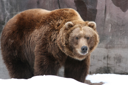

In [72]:
from wget import download
from fastai.vision.core import Image # don't use PIL

dest = "images"
isdir = os.path.isdir(dest)
print(f"Does isdir => {isdir} exist for dest => {dest}")
dir = download(ims[0], dest)
print(f"Downloading to dir : {dir}")

im = Image.open(dir)  # type: ignore
im.to_thumb(128, 128)  # type: ignore

In [5]:
from fastai.vision.utils import download_images
from fastcore.utils import Path

bear_types = 'grizzly', 'black', 'teddys'
bear_image_dir = Path('Bears')
if not bear_image_dir.exists():
    print(f"making directory [{bear_image_dir}] and downloading url results")
    bear_image_dir.mkdir()
    for o in bear_types:
        dest = (bear_image_dir/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} bear')
        download_images(dest, urls=results.attrgot('contentUrl'))
else:
    print(f"directory [{bear_image_dir}] already exists, skipping download")

directory [Bears] already exists, skipping download


In [6]:
from fastai.vision.utils import get_image_files, verify_images

print(bear_types)
bear_image_dir = Path('Bears')
fns = get_image_files(bear_image_dir)
# originally 384 imaged - UPDATE manually removed one image => 383
print(len(fns.items))
# Some downloads will be corrupt, let's check for them
failed = verify_images(fns)
print(len(failed.items))
# Some downloads will be corrupt, let's check for them
# 328 after removing 56 corrupt images - UPDATE manually removed one image => 327
failed.map(Path.unlink)
print(len(fns.items))

('grizzly', 'black', 'teddys')
327
0
327


In [7]:
from fastai.vision.utils import DataBlock, CategoryBlock, get_image_files, RandomSplitter, parent_label
from fastai.vision.data import ImageBlock
from fastai.vision.augment import Resize

bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock),   # type: ignore
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42), # set seed so that the 20% validation data is always the same
    get_y=parent_label, # y is the label, i.e. the dependent variable to x
    item_tfms=Resize(128)  # type: ignore : tensors have to be the same size, Preprocess and Resize to 128x128
)

dls = bears.dataloaders(bear_image_dir)

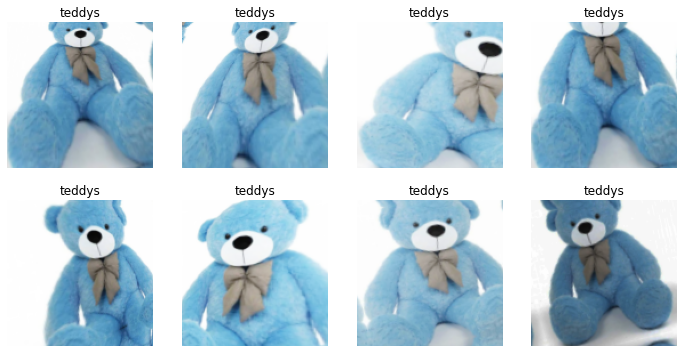

In [8]:
from fastai.vision.augment import aug_transforms
from fastai.vision.augment import RandomResizedCrop

# data augmentation - randomnly transform, warp, brighten, contrast ... etc
# TODO : Find out if augmented data > larger dataset ... are latent connections stronger when starting from
# a shared base image vs a larger set of random images
# tranforms/warp, brighten, contrast likely isn't as resilient as enourmous dataset to capture 3D turnaround and depth
# ... but it's a start, since getting such a large dataset may be intractable
bears = bears.new(
    item_tfms=RandomResizedCrop(128, min_scale=0.5),   # type: ignore
    batch_tfms=aug_transforms(mult=2)
)

dls = bears.dataloaders(bear_image_dir)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [9]:
from fastai.vision.learner import vision_learner
from fastai.vision.learner import error_rate
from fastai.vision.models import resnet50, ResNet50_Weights
# from fastai.vision.models import resnet18, ResNet18_Weights

# Best available weights (currently alias for IMAGENET1K_V2)
# Note that these weights may change across versions
resnet50(weights=ResNet50_Weights.DEFAULT)
learn = vision_learner(dls, resnet50, metrics=error_rate)

# TODO : Learn and explain the difference bewtween resenet50 and resnet18
# resnet18(weights=ResNet18_Weights.DEFAULT)
# learn = vision_learner(dls, resnet18, metrics=error_rate)


/Users/mton/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/mton/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
#from fastai.vision.learner import Learner
# TODO : Find out why importing from fastai.vision.learner NOT INCLUDE learn.fine_tune
# also ... the progress bar doesn't show up unless * is imported lol
from fastai.vision.all import Learner

learn.fine_tune(4)

[0, 1.066645622253418, 0.0869414284825325, 0.03076923079788685, '00:40']
[0, 0.17426812648773193, 0.16343408823013306, 0.03076923079788685, '00:44']
[1, 0.1411062479019165, 0.21094347536563873, 0.04615384712815285, '00:53']
[2, 0.12651893496513367, 0.300401508808136, 0.04615384712815285, '00:46']
[3, 0.11257465183734894, 0.29152336716651917, 0.04615384712815285, '00:47']


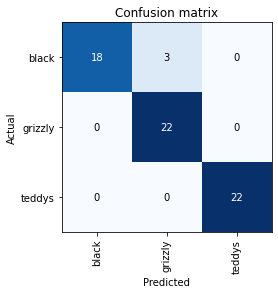

In [11]:
from fastai.vision.learner import ClassificationInterpretation

# Use fastai tool to measure early model results
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

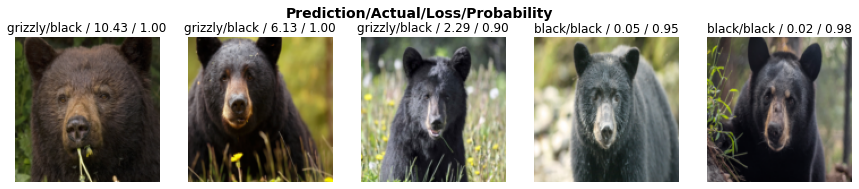

In [70]:
# Show the top 5 most confused images and manually check their labels
# This is a benefit of standing up a rough model quickly FIRST
# and then MANUALLY checking the results AFTERWARDS : much more efficient
interp.plot_top_losses(5, nrows=1)

In [71]:
from fastai.vision.widgets import ImageClassifierCleaner

cleaner = ImageClassifierCleaner(learn)
cleaner # type: ignore

In [14]:
print(f"cleaner >> count {len(cleaner.fns.items)}")

# delete teddy bear images with children occluding the foreground and black/grizzly bears mixed in
print(f"cleaner >> delete {len(cleaner.delete())}")
for idx in cleaner.delete():
    cleaner.fns[idx].unlink()

print(f"cleaner >> changed {len(cleaner.change())}")
for idx,cat in cleaner.change():
    print(f"cleaner >> id {idx} cat {cat}")
    shutil.move(str(cleaner.fns[idx]), bear_image_dir/cat)   # type: ignore 

cleaner >> count 30
cleaner >> delete 0
cleaner >> changed 0


In [15]:
# saves a export.pkl file in the current directory
learn.export()

# check that the export.pkl file exists in the current directory
bear_image_dir = Path()
bear_image_dir.ls(file_exts='.pkl')  # type: ignore


(#1) [Path('export.pkl')]

In [22]:
from fastai.vision.learner import load_learner

# inference = when we use a model to make predictions on new data as opposed to training
learn_inf = load_learner(bear_image_dir/'export.pkl') # type: ignore

'''
learn_inf.predict('images/grizzly.jpg') #grizzly bear
learn_inf.predict('images/teddy.jpeg') #teddy bear
learn_inf.predict('images/red_panda.jpeg') #black bear lol
'''

learn_inf.predict('images/pinkbear.jpeg') #teddy bear

# returns predicted category, and probability of each category
# ('teddys', TensorBase(2), TensorBase([5.1859e-05, 2.4720e-07, 9.9995e-01]))
learn_inf.dls.vocab

['black', 'grizzly', 'teddys']

In [ ]:
#from fastai.vision.all import *
#from fastai.vision.widgets import *
from fastai.vision.widgets import widgets, FileUpload

btn_upload = widgets.FileUpload()
btn_upload # type: ignore

In [45]:

from fastai.vision.widgets import PILImage
type(btn_upload)
# print(btn_upload.data[-1])
#dir(btn_upload)
#doc(PILImage.create)
#doc(widgets.FileUpload)
#print(btn_upload.data[-1])

#img = PILImage.create(btn_upload.data[-1])

# TODO : Figure out how to get the image from the FileUpload widget
# Trash move just hack past it for now
imgPathHack = "images/red_panda.jpeg"
img = PILImage.create(imgPathHack)

In [ ]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl:
    display(img.to_thumb(128,128)) # type: ignore

out_pl # type: ignore



In [ ]:
pred, pred_idx, probs = learn_inf.predict(imgPathHack)

lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred # type: ignore


btn_run = widgets.Button(description = 'Classify')

def on_click_classify(change):
    #TODO : Fix this trash hack
    img=PILImage.create(imgPathHack)
    out_pl.clear_output()
    with out_pl:
        display(img.to_thumb(128,128)) # type: ignore
    pred, pred_idx, probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
    print(lbl_pred.value)

btn_run.on_click(on_click_classify)
btn_run # type: ignore

In [69]:
from fastai.vision.widgets import VBox, widget

# TDDO : Why isn't this presenting the widgets in a vertical stack? 
VBox([widgets.Label('Select your bear'), btn_upload, btn_run, out_pl, lbl_pred])


In [68]:
from fastai.vision.all import * # type: ignore
from fastai.vision.widgets import widget, Image

im = Image.open('images/grizzly.jpg').to_thumb(256,512) # type: ignore

VBox([widgets.HTML('Puppy'), widget(im, max_width="192px")])

In [ ]:
%pip install voila

In [74]:
!jupyter serverextension enable --sys-prefix voila

Enabling: voila
- Writing config: /Users/mton/miniconda3/envs/torch-gpu/etc/jupyter
    - Validating...
      voila 0.4.0 OK
